# NMF modeling for player recomendations

Non negative matrix factorization(NMF) is a feature reduction technique that decomposes a matrix into two smaller matricies that can be used to cluster features from the original matrix into topics as well as calculate the distance between samples in the original matrix to allow for recomendations between the closest samples to be created. I will be using NMF to generate player recomendations to find who has the cloest stats to  'Walker Zimmerman' and some of the other best players in the MLS 

In [5]:
## import packages and tools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from soccerplots.radar_chart import Radar
from sklearn.decomposition import NMF 
from sklearn.preprocessing import Normalizer ,MaxAbsScaler
from sklearn.pipeline import make_pipeline
from utils import save_file,radar_compare 

In [17]:
## load data
df = pd.read_csv('../data/normed_W.csv')
df.index= df['Unnamed: 0'].values
df.drop('Unnamed: 0',axis=1,inplace=True)
df

,defensive passing,dribbling,defensive actions,short passing,playing time,tackling,attacking play,passing volume,progressive passing
Carles Gil,0.015992,0.273852,0.000000,0.000000,0.211066,0.000000,0.103804,0.709296,0.605248
Julian Gressel,0.033067,0.042370,0.054048,0.000000,0.152537,0.132843,0.144895,0.268178,0.927557
Emanuel Reynoso,0.003344,0.398234,0.000000,0.000000,0.281587,0.370866,0.163577,0.725926,0.266156
Albert Rusnák,0.024410,0.133041,0.000000,0.000000,0.549056,0.000000,0.301156,0.608900,0.467747
Maximiliano Moralez,0.012592,0.076172,0.000000,0.000000,0.296892,0.244998,0.316279,0.693596,0.514551
...,...,...,...,...,...,...,...,...,...
Matt Turner,0.637269,0.000000,0.000000,0.000000,0.769379,0.000000,0.000000,0.035642,0.025948
Przemysław Tytoń,0.633983,0.000000,0.068980,0.585994,0.499919,0.000000,0.000000,0.000000,0.000000
William Yarbrough,0.357936,0.000000,0.000000,0.000000,0.933746,0.000000,0.000000,0.000000,0.000000
Tomas Romero,0.574028,0.000832,0.000000,0.303677,0.759204,0.043355,0.000000,0.000000,0.000000


In [11]:
df

,Unnamed: 0,defensive passing,dribbling,defensive actions,short passing,playing time,tackling,attacking play,passing volume,progressive passing
0,Carles Gil,0.015992,0.273852,0.000000,0.000000,0.211066,0.000000,0.103804,0.709296,0.605248
1,Julian Gressel,0.033067,0.042370,0.054048,0.000000,0.152537,0.132843,0.144895,0.268178,0.927557
2,Emanuel Reynoso,0.003344,0.398234,0.000000,0.000000,0.281587,0.370866,0.163577,0.725926,0.266156
3,Albert Rusnák,0.024410,0.133041,0.000000,0.000000,0.549056,0.000000,0.301156,0.608900,0.467747
4,Maximiliano Moralez,0.012592,0.076172,0.000000,0.000000,0.296892,0.244998,0.316279,0.693596,0.514551
...,...,...,...,...,...,...,...,...,...,...
536,Matt Turner,0.637269,0.000000,0.000000,0.000000,0.769379,0.000000,0.000000,0.035642,0.025948
537,Przemysław Tytoń,0.633983,0.000000,0.068980,0.585994,0.499919,0.000000,0.000000,0.000000,0.000000
538,William Yarbrough,0.357936,0.000000,0.000000,0.000000,0.933746,0.000000,0.000000,0.000000,0.000000
539,Tomas Romero,0.574028,0.000832,0.000000,0.303677,0.759204,0.043355,0.000000,0.000000,0.000000


In [28]:
## set index and drop negative and categotical columns 
X = df.set_index('player_name')

# remove categorical and features with negative values
X = X.drop(columns= ['Base Salary','Player', 'Club',
                     'Nation', 'Position','fb_id', 'Squad_from_op','G-xG','np:G-xG'])
X.shape

(705, 100)

In [85]:
## select key features to input into NMF 
X = X[[ 'Tackle_pct_won', 'Nineties', 'xA',
       'Key_pass', 'Comp_prog', 'Total_Cmp', 'Total_Att', 'Total_Cmp_pct',
       'Total_Tot_Dist', 'Total_Prg_Dist', 'Short_Cmp', 'Short_Att',
        'Medium_Cmp', 'Medium_Att', 
       'Long_Cmp', 'Long_Att', 'Long_Cmp_pct', 'touches', 'touches_def_box',
       'touches_def_3rd', 'touches_mid_3rd', 'touches_att_3rd',
       'touches_att_box', 'touch_live', 'dribble_Succ', 'dribble_Att',
       'dribble_Succ_pct', 'num_dribble_past', 'dribble_megs', 'carries',
       'carries_dist', 'carries_prog_dist', 'carries_prog', 'carries_att_3rd',
       'carries_att_box', 'miss_control', 'dispossed', 'recep_targ',
       'recep_succ', 'recept_pct', 'Fouls_drawn', 'Offsides', 'Crosses',
       'PK_won', 'Aerial_win_pct', 'Gls', 'Sh', 'SoT', 'SoT%', 'Sh/90',
       'SoT/90', 'G/Sh', 'G/SoT', 'Dist', 'FK', 'PK', 'PKatt', 'xG', 'npxG',
       'npxG/Sh', 'pAdj_Total_tackles', 'pAdj_Tackles_Won',
       'pAdj_Tackles_Def_3rd', 'pAdj_Tackles_Mid_3rd', 'pAdj_Tackles_Att_3rd',
       'pAdj_Num_Dribblers_tackled', 'pAdj_Num_Dribbled_past', 
       'pAdj_Blocked_shots', 'pAdj_Blocked_SOT', 'pAdj_Blocked_pass',
       'pAdj_Interceptions', 'pAdj_Tackles_and_Ints', 'pAdj_Clearences',
      'pAdj_Red_cards','pAdj_Fouls', 'pAdj_def_interceptions', 'pAdj_Recoveries',
       'pAdj_Aerial_Duels_lost', 'lost_tackles', 'True_tackle_pct',
       'pAdj_Tackle_int_blocks', 'avg_shrt+med_pass_pct', 'pct_long_balls',
       'prog_carry+lng_comp+crosses', 'attacking_touches']]
# work with players who have played at least 5 games 
X = X.loc[(X['Nineties']>5)]
X.shape

(541, 85)

# Overview -

NMF or Non Negative Matrix Factorization is widely used for topic modeling and document clustering but there are many examples of NMF being used to cluster other kinds of datasets such as classifying Companies on extra financial criteria.https://towardsdatascience.com/using-nmf-to-classify-companies-a77e176f276f . I am going to use NMF to classify my MLS 2021 data set by the "topic" or ,grouping of player stats,that I will call "skill set group". I will use the skill sets to classify players in the league and then use a normalized version of the decomposed matrix to identify players who are closest to Key players Identified in my EDA . At the end I should have all players classified by a key skill set group. Players closest to the target players identified show how franchises could use NMF to Identify other players that fit into roles played by players in the MLS. 

# NMF matrix break down -
With the player matrix X being of n players(rows) and f features(player stats) (n x f)
and 
c = number of Skill set groups generated 

## Weight matrix - weights of each row for each skill set group or topic 
This matrix has rows filled by players  with the skill set features generated  by the NMF algorithm as the columns give you the weight matrix. 

#W = n x c 

## Hidden layer matrix - hidden layer of feature values for each skill set group
This matrix has rows of players features with  skill set groups as the columns. 
H = F x c

## The matrix multiplication of W (weight)* H(hidden) approximates the original X player matrix

W x H approximates X allowing for player data to be observed in a  lower dimensional space by comparing player skill set values in the weight matrix.  

## The W weight matrix ias than used to find players closest to the target player in question

The distance between the topic values of each player in the W matrix can be used to measure who is the most simular allowing for recommendations of players closest to the target player to be created.

The skill set group that has the highest ranking for each player is used to classify or label groups of players who are Rows filled by players  with the skill set features generated  by the NMF algorithm as the columns gives you the weight matrix,  W = n x c.similar in their player stats features. 



In [86]:
# function to viz skill groups and players most associated with skill group

def display_features(H,W,feature_names, X_matrix ,no_top_features, no_top_players):
    """ visualize skill get group and highest ranked players in group """
    topics = {}
    # iterate through topics in topic-term matrix, 'H' aka
    # H is the hidden layer which is shape (F x C) feature times topic matrix
    for topic_idx, topic in enumerate(H):
        print("Topic %d:" % (topic_idx))
        print(" ".join([ (feature_names[i] + " (" + str(topic[i].round(2)) + ")")
          for i in topic.argsort()[:-no_top_features - 1:-1]]))
        
        # add features to topics dictionary for later assesment. 
        
        topics[topic_idx] = [ (feature_names[i] + " (" + str(topic[i].round(2)) + ")") 
                             for i in topic.argsort()[:-(no_top_features+3) - 1:-1]]
        
        top_player_indicies = np.argsort( W[:,topic_idx] )[::-1][0:no_top_players]
        for p_index in top_player_indicies:
            
            print(p_index," ",X_matrix.index[p_index])
    
    return topics 

## add skill group to player feature to use for classification

def add_skill_group(X,W):
    df_new = X.copy()
    # Get the top predicted topic and add to df copy 
    df_new['pred_topic_num']= [np.argsort(each)[::-1][0] for each in W]
  
    return df_new

- tuning of max_iter parameter to allow for model convergance 

In [88]:
for test in np.arange(100,1000,100):
    c = 11
    # Create a MaxAbsScaler: scaler
    transformer = MaxAbsScaler().fit(X)

    # scale data
    scaled_X= transformer.transform(X)

    # Create an NMF model: nmf

    nmf = NMF(n_components=c,max_iter=test,init='nndsvda',  random_state=42)

    W = nmf.fit_transform(scaled_X)
    H = nmf.components_
    err = nmf.reconstruction_err_

    print(nmf,'error :',err, '\n', ' W shape',W.shape,'H shape ',H.shape)           


# topics = display_features(H,W,feature_names, X, no_top_features,no_top_players)

/Users/robertrustia/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 100 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
/Users/robertrustia/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
/Users/robertrustia/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 300 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


NMF(init='nndsvda', max_iter=100, n_components=11, random_state=42) error : 15.267031395899144 
  W shape (541, 11) H shape  (11, 85)
NMF(init='nndsvda', n_components=11, random_state=42) error : 15.241489440260304 
  W shape (541, 11) H shape  (11, 85)
NMF(init='nndsvda', max_iter=300, n_components=11, random_state=42) error : 15.237397443966058 
  W shape (541, 11) H shape  (11, 85)
NMF(init='nndsvda', max_iter=400, n_components=11, random_state=42) error : 15.2373182856613 
  W shape (541, 11) H shape  (11, 85)
NMF(init='nndsvda', max_iter=500, n_components=11, random_state=42) error : 15.2373182856613 
  W shape (541, 11) H shape  (11, 85)
NMF(init='nndsvda', max_iter=600, n_components=11, random_state=42) error : 15.2373182856613 
  W shape (541, 11) H shape  (11, 85)
NMF(init='nndsvda', max_iter=700, n_components=11, random_state=42) error : 15.2373182856613 
  W shape (541, 11) H shape  (11, 85)
NMF(init='nndsvda', max_iter=800, n_components=11, random_state=42) error : 15.23731

###max_iter tuning 
- more than 300 iterations required to converge the model. will go with 400 iterations. 

## Inital NMF attempt with c = 11 skill group topics 

In [89]:

c = 11
# Create a MaxAbsScaler: scaler
transformer = MaxAbsScaler().fit(X)

# scale data
scaled_X= transformer.transform(X)

# Create an NMF model: nmf

nmf = NMF(n_components=c,max_iter=400,init='nndsvda', random_state=42)

W = nmf.fit_transform(scaled_X)
H = nmf.components_
err = nmf.reconstruction_err_

print(nmf,'error :',err, '\n', ' W shape',W.shape,'H shape ',H.shape)

            
feature_names = X.columns.values
no_top_features = 4
no_top_players = 3

topics = display_features(H,W,feature_names, X, no_top_features,no_top_players)

NMF(init='nndsvda', max_iter=400, n_components=11, random_state=42) error : 15.2373182856613 
  W shape (541, 11) H shape  (11, 85)
Topic 0:
recept_pct (12.25) avg_shrt+med_pass_pct (11.91) touches_def_box (10.31) pct_long_balls (10.06)
526   Zac MacMath
488   Brad Guzan
518   Maxime Crépeau
Topic 1:
touches_att_box (4.97) npxG (4.36) SoT (4.34) xG (4.22)
192   Adam Buksa
45   Valentín Castellanos
106   Ola Kamara
Topic 2:
pAdj_Tackles_Mid_3rd (3.56) pAdj_Total_tackles (3.18) pAdj_Tackles_Won (3.17) pAdj_Tackles_and_Ints (2.65)
409   Judson
462   Franco Ibarra
246   Eric Remedi
Topic 3:
xA (1.93) Key_pass (1.74) Comp_prog (1.53) Long_Att (1.48)
2   Emanuel Reynoso
0   Carles Gil
6   Lucas Zelarayán
Topic 4:
pAdj_Clearences (2.18) pAdj_Blocked_shots (1.8) Aerial_win_pct (1.49) touches_def_3rd (1.45)
426   Nathan Cardoso
392   Jon Bell
388   Wyatt Omsberg
Topic 5:
Total_Cmp_pct (1.1) Short_Cmp (1.08) Short_Att (1.07) avg_shrt+med_pass_pct (1.04)
266   Bryce Duke
499   Kamohelo Mokotjo
54

In [90]:
# check groups 
df_new = add_skill_group(X,W)
df_new['pred_topic_num'].value_counts()

10    121
8     120
7     109
5      64
6      52
4      33
9      33
0       8
3       1
Name: pred_topic_num, dtype: int64

## Tuning Insight 
- 11 skill groups lead to only 9 clusters shown above. I will reduce c to be able to have more balanced clusters. 
- The highest rated players for each skill set are related in playing style showing that the associations between players built out by NMF look promising 

In [102]:
# try 8 skill set groups to look for balanced groups  


c = 9

nmf = NMF(n_components=c,max_iter=1000,init='nndsvda', l1_ratio=.05, random_state=42)

W = nmf.fit_transform(scaled_X)
H = nmf.components_
err = nmf.reconstruction_err_

print(nmf,'error :',err, '\n', ' W shape',W.shape,'H shape ',H.shape)
df_new = add_skill_group(X,W)
print(df_new['pred_topic_num'].value_counts())
            
feature_names = X.columns.values
no_top_features = 4
no_top_players = 5

topics = display_features(H,W,feature_names, X, no_top_features,no_top_players)

NMF(init='nndsvda', l1_ratio=0.05, max_iter=1000, n_components=9,
    random_state=42) error : 16.097065673959523 
  W shape (541, 9) H shape  (9, 85)
7    99
8    98
5    87
6    79
4    70
3    48
2    40
0    18
1     2
Name: pred_topic_num, dtype: int64
Topic 0:
recept_pct (9.36) avg_shrt+med_pass_pct (8.98) pct_long_balls (8.19) touches_def_box (7.97)
488   Brad Guzan
518   Maxime Crépeau
526   Zac MacMath
530   David Ochoa
428   J.T. Marcinkowski
Topic 1:
dribble_Succ (2.71) num_dribble_past (2.63) dribble_Att (2.52) dispossed (2.31)
51   Yeferson Soteldo
2   Emanuel Reynoso
136   Brian Rodríguez
6   Lucas Zelarayán
0   Carles Gil
Topic 2:
pAdj_Clearences (2.37) pAdj_Blocked_shots (2.05) touches_def_3rd (1.81) pAdj_def_interceptions (1.49)
426   Nathan Cardoso
348   Alan Franco
417   Daniel Steres
365   Rudy Camacho
422   Francisco Calvo
Topic 3:
Total_Cmp_pct (1.71) avg_shrt+med_pass_pct (1.66) recept_pct (1.44) Long_Cmp_pct (1.28)
499   Kamohelo Mokotjo
459   Ralph Priso-Mbongu

## Skill Set Group Tuning 
- with c set to 8 skill set groups there are 8 clusters of players created by this model. 
- checking quality of skill set groups with dataframe below

In [117]:
skill_sets = pd.DataFrame(topics )
columns =['defensive passing','dribbling','defensive actions',
                'short passing','playing time','tackling',
                'attacking play','passing volume','progressive passing']
skill_sets.columns = columns
skill_sets

,defensive passing,dribbling,defensive actions,short passing,playing time,tackling,attacking play,passing volume,progressive passing
0,recept_pct (9.36),dribble_Succ (2.71),pAdj_Clearences (2.37),Total_Cmp_pct (1.71),Nineties (2.1),pAdj_Tackles_Mid_3rd (1.1),touches_att_box (1.37),touches_mid_3rd (0.87),Crosses (1.07)
1,avg_shrt+med_pass_pct (8.98),num_dribble_past (2.63),pAdj_Blocked_shots (2.05),avg_shrt+med_pass_pct (1.66),Total_Cmp_pct (1.69),pAdj_Total_tackles (0.97),SoT (1.3),recep_succ (0.84),touches_att_3rd (0.7)
2,pct_long_balls (8.19),dribble_Att (2.52),touches_def_3rd (1.81),recept_pct (1.44),avg_shrt+med_pass_pct (1.62),pAdj_Tackles_Won (0.97),npxG (1.23),Total_Cmp (0.76),attacking_touches (0.65)
3,touches_def_box (7.97),dispossed (2.31),pAdj_def_interceptions (1.49),Long_Cmp_pct (1.28),dribble_Succ_pct (1.45),pAdj_Tackles_and_Ints (0.84),xG (1.19),Total_Att (0.76),Short_Att (0.54)
4,Long_Att (7.87),carries_prog (1.95),pAdj_Interceptions (1.48),dribble_Succ_pct (1.26),Long_Cmp_pct (1.39),pAdj_Num_Dribbled_past (0.82),Sh (1.18),carries (0.75),xA (0.52)
5,Total_Prg_Dist (7.76),attacking_touches (1.84),Aerial_win_pct (1.39),Dist (1.16),recept_pct (1.39),pAdj_Num_Dribblers_tackled (0.81),Offsides (1.03),recep_targ (0.73),recept_pct (0.51)
6,touches_def_3rd (7.18),dribble_megs (1.83),pAdj_Tackle_int_blocks (1.39),Short_Att (0.87),Short_Att (0.7),pAdj_Tackle_int_blocks (0.76),Gls (1.02),Total_Tot_Dist (0.72),pAdj_Blocked_pass (0.5)


In [119]:
W.shape

(541, 9)

In [122]:
dfw= pd.DataFrame(W,columns=columns,index = X.index)
dfw

,defensive passing,dribbling,defensive actions,short passing,playing time,tackling,attacking play,passing volume,progressive passing
player_name,,,,,,,,,
Carles Gil,0.013093,0.224208,0.000000,0.000000,0.172804,0.000000,0.084986,0.580714,0.495527
Julian Gressel,0.025680,0.032906,0.041975,0.000000,0.118464,0.103169,0.112529,0.208273,0.720363
Emanuel Reynoso,0.002525,0.300686,0.000000,0.000000,0.212611,0.280021,0.123508,0.548108,0.200960
Albert Rusnák,0.014430,0.078649,0.000000,0.000000,0.324585,0.000000,0.178034,0.359962,0.276517
Maximiliano Moralez,0.009740,0.058921,0.000000,0.000000,0.229654,0.189513,0.244651,0.536516,0.398020
...,...,...,...,...,...,...,...,...,...
Matt Turner,0.092180,0.000000,0.000000,0.000000,0.111290,0.000000,0.000000,0.005156,0.003753
Przemysław Tytoń,0.080818,0.000000,0.008793,0.074700,0.063728,0.000000,0.000000,0.000000,0.000000
William Yarbrough,0.078064,0.000000,0.000000,0.000000,0.203646,0.000000,0.000000,0.000000,0.000000


## Use skill Set group values to create ranks to use for clustering and comparisons

In [132]:
for col in dfw.columns.values:
    title = col +' rank'
    dfw[title] = dfw[col].rank(pct=True,na_option = 'bottom',ascending=True)
dfw[['defensive actions','defensive actions rank']].nlargest(5,columns='defensive actions rank')

,defensive actions,defensive actions rank
player_name,,
Nathan Cardoso,0.355321,1.000000
Alan Franco,0.315812,0.998152
Daniel Steres,0.308983,0.996303
Rudy Camacho,0.305769,0.994455
Francisco Calvo,0.301305,0.992606


## SJE new defenive signing Francisco Calvo comes up in top 5 rank with Nathan Cordoso for the defensive actions skill set group

In [134]:
# save dfw for modeling and coparison

dfw.to_csv('../data/W_ranks.csv', encoding='utf-8', index=False)

In [ ]:
# save original W matrix for calculating cosine simularity between players

transformer = Normalizer().fit(W)
normed_X= transformer.transform(W)
# can add back club and salary here 
normed_df = pd.DataFrame(normed_X,index=X.index.values)

normred

In [39]:
transformer = Normalizer().fit(W)
normed_X= transformer.transform(W)
# can add back club and salary here 
normed_df = pd.DataFrame(normed_X,index=X.index.values)


In [40]:
# make df of only key features 
cdf = df[['player_name','Club',
       'Aerial_win_pct',
       'pAdj_Num_Dribblers_tackled',
       'pAdj_Num_Dribbled_past','pAdj_Tackles_and_Ints', 'pAdj_Clearences',
       'pAdj_Fouls','pAdj_Recoveries', 'True_tackle_pct',
       'pAdj_Tackle_int_blocks', 
       'pct_long_balls', 'prog_carry+lng_comp+crosses',
       ]]

# def_df = cdf.loc[cdf['player_name'].isin(['Nathan Cardoso','Alan Franco','Andreu Fontàs','Andrés Reyes','Matt Besler'])]
cdf.rename(columns={'pAdj_Tackles_and_Ints':'Tackles_and_Ints','pAdj_Clearences':'Clearences','pAdj_Fouls':'Fouls',
                   'pAdj_Recoveries':'Recoveries',
                  'pAdj_Tackle_int_blocks':'Tackle_int_blocks','pAdj_Num_Dribblers_tackled':'Num_Dribblers_tackled',
                  'pAdj_Num_Dribbled_past':'Num_Dribbled_past'},inplace=True)

params = list(cdf.columns)[2:]

/Users/robertrustia/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [41]:
jm = normed_df.loc['Albert Rusnák']
sims = normed_df.dot(jm)

sims.nlargest(10)

Albert Rusnák           1.000000
Javier Eduardo López    0.972366
Diego Fagúndez          0.965011
Yimmi Chará             0.962488
Djordje Mihailovic      0.958533
Cole Bassett            0.954867
Maximiliano Moralez     0.953977
Cristian Roldan         0.953345
Cecilio Domínguez       0.952499
Hany Mukhtar            0.950801
dtype: float64

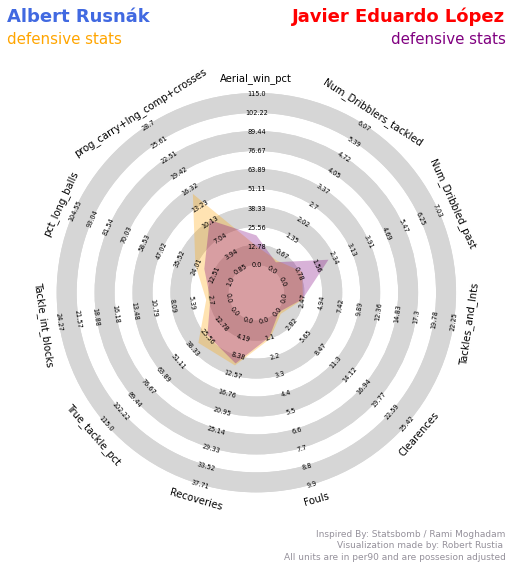

In [42]:
radar_compare('Albert Rusnák','Javier Eduardo López',params,cdf)

Having another creative attacking midfielder in Diego Fagundez as the closest player to Abert Rusnak helps validats the skill set groups created. 

In [43]:
tt = normed_df.loc['Tommy Thompson']
sims = normed_df.dot(tt)

sims.nlargest(10)

Tommy Thompson     1.000000
Zorhan Bassong     0.981675
Marco Farfan       0.960954
Marcos López       0.950946
Malte Amundsen     0.948435
Julian Araujo      0.944638
Pablo Bonilla      0.941431
DeJuan Jones       0.940822
Ema Twumasi        0.936313
Niko Hämäläinen    0.933341
dtype: float64

In [44]:
wz = normed_df.loc['Walker Zimmerman']
sims = normed_df.dot(wz)

sims.nlargest(10)

Walker Zimmerman     1.000000
Oswaldo Alanís       0.996763
Jonathan Mensah      0.996099
Ranko Veselinović    0.995324
Bill Tuiloma         0.993153
Tanner Beason        0.993146
Xavier Arreaga       0.991141
Robin Jansson        0.990437
Nkosi Burgess        0.989756
Jack Elliott         0.989574
dtype: float64

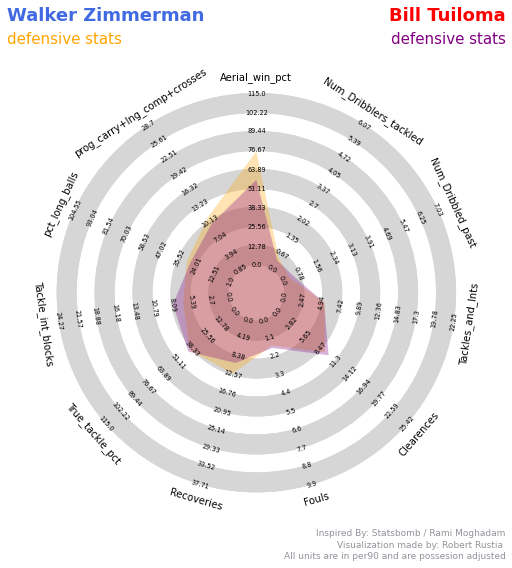

In [45]:
radar_compare('Walker Zimmerman','Bill Tuiloma',params,cdf)

In [38]:
jm = normed_df.loc['Jonathan Mensah']
sims = normed_df.dot(jm)

sims.nlargest(10)

Jonathan Mensah      1.000000
Tanner Beason        0.997402
Antonio Carlos       0.996732
Walker Zimmerman     0.996099
Oswaldo Alanís       0.995707
Ranko Veselinović    0.994264
Rudy Camacho         0.993281
Justen Glad          0.992826
Bill Tuiloma         0.992724
Xavier Arreaga       0.992455
dtype: float64

In [46]:
jm = normed_df.loc['Nathan Cardoso']
sims = normed_df.dot(jm)

sims.nlargest(10)

Nathan Cardoso          1.000000
Alan Franco             0.971050
Andrés Reyes            0.970232
Donovan Pines           0.965230
Francisco Calvo         0.959289
Johan Kappelhof         0.954601
Nick Hagglund           0.953494
Rodrigo Schlegel        0.950793
Gustavo Vallecilla      0.945636
Nicolas Isimat-Mirin    0.945454
dtype: float64

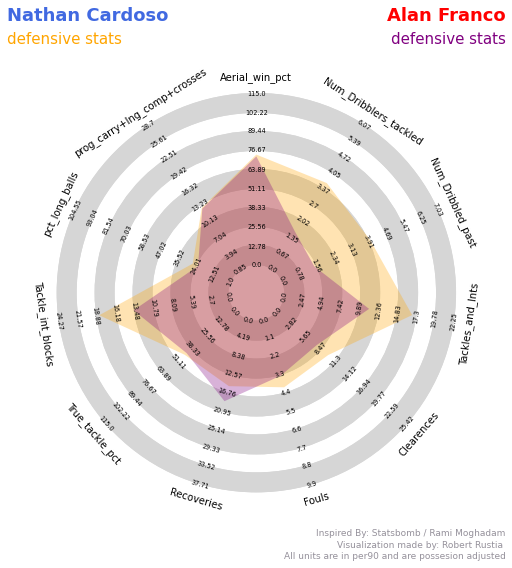

In [48]:
radar_compare('Nathan Cardoso','Alan Franco',params,cdf)

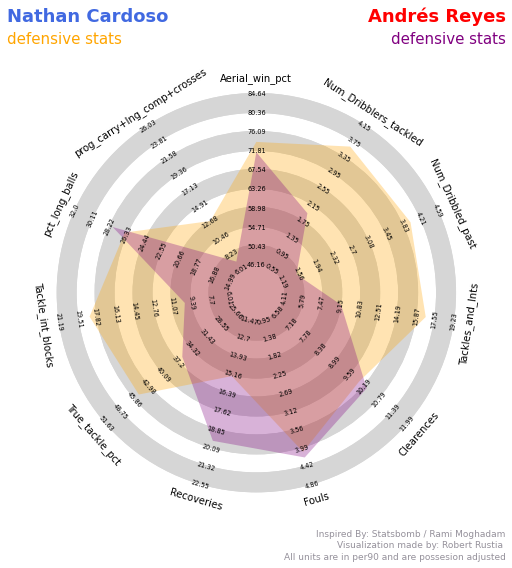

In [27]:
# make df of only key features 
cdf = df[['player_name','Club',
       'Aerial_win_pct',
       'pAdj_Num_Dribblers_tackled',
       'pAdj_Num_Dribbled_past','pAdj_Tackles_and_Ints', 'pAdj_Clearences',
       'pAdj_Fouls','pAdj_Recoveries', 'True_tackle_pct',
       'pAdj_Tackle_int_blocks', 
       'pct_long_balls', 'prog_carry+lng_comp+crosses',
       ]]

def_df = cdf.loc[cdf['player_name'].isin(['Nathan Cardoso','Alan Franco','Andreu Fontàs','Andrés Reyes','Matt Besler'])]
def_df.rename(columns={'pAdj_Tackles_and_Ints':'Tackles_and_Ints','pAdj_Clearences':'Clearences','pAdj_Fouls':'Fouls',
                   'pAdj_Recoveries':'Recoveries',
                  'pAdj_Tackle_int_blocks':'Tackle_int_blocks','pAdj_Num_Dribblers_tackled':'Num_Dribblers_tackled',
                  'pAdj_Num_Dribbled_past':'Num_Dribbled_past'},inplace=True)

params = list(def_df.columns)[2:]
radar_compare('Nathan Cardoso','Andrés Reyes',params,def_df)
